In [1]:
import numpy as np
%load_ext autoreload
%autoreload 2
import os
os.environ["OMP_NUM_THREADS"] = "1"
from train import *
from train_config import load_config


In [2]:
plt.rcParams.update({'font.size': 7,
                     'font.family': 'arial',
                     'pdf.fonttype': 42,
                     'ps.fonttype': 42,
                     'savefig.dpi': 480})
from matplotlib.colors import LinearSegmentedColormap
color_dict = {
    'ANTI_DM': '#2b8a3e',
    'PRO_DM': '#f59f00',
    'PRO_M': '#b30000',
    'PRO_D': '#be4bdb',
    'ANTI_M': '#364fc7',
    'ANTI_D': '#21B8CF',
}

label_dict = {
    'ANTI_DM': 'DMAnti', # abbrev: Adm
    'PRO_DM': 'DMPro',  # abbrev: Pdm
    'PRO_M': 'MemoryPro', # abbrev: Pm
    'PRO_D': 'DelayPro',  # abbrev: Pd
    'ANTI_M': 'MemoryAnti',  # abbrev: Am
    'ANTI_D': 'DelayAnti',  # abbrev: Ad
}

### model comparison

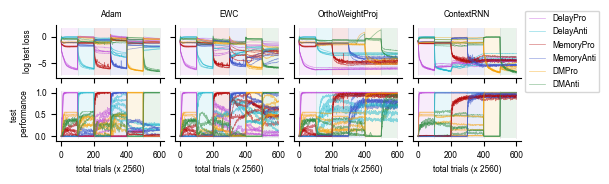

In [4]:
plt.rcParams.update({'font.size': 6,})
task_order = 'PdAdPmAmPdmAdm' # ['PdAdPmAmPdmAdm', 'PdPmAdAmPdmAdm', 'PdmAdmPdAdPmAm', 'PmPdAmAdPdmAdm']
nonlin_str = '_relu'
nonlin_save_str = '_tanh' if nonlin_str == '' else nonlin_str
model_titles = ['Adam', 'EWC', 'OrthoWeightProj', 'ContextRNN']
n_model = len(model_titles)

fig, axes = plt.subplots(2, n_model, figsize=(1.5 * n_model, 1.5), sharex=True, sharey='row')
fig.subplots_adjust(wspace=0.1, hspace=0.2)
task_list, dn_ckpt = None, None
for i_model in range(n_model):
    for seed in range(5):
        if i_model == 0:  # 'Adam'
            save_name = f'leakyrnn_v1{nonlin_str}_{task_order}_AdamWithProj_sd{seed}'
        elif i_model == 1: # 'EWC'
            save_name = f'leakyrnn_v1_ewc50000{nonlin_str}_{task_order}_AdamWithProj_sd{seed}'
        elif i_model == 2: # 'OrthoWeightProj'
            save_name = f'leakyrnn_v1_proj{nonlin_str}_{task_order}_AdamWithProj_sd{seed}'
        else:  # 'ContextRNN'
            save_name = f'cxtrnn_seq_v2_gating3_ioZ{nonlin_str}_{task_order}_tskm512_sd{seed}'
        config = load_config(save_name)
        config['retrain'] = False
        assert config['strict'] == True
        train_fn = eval(config.get('train_fn', 'train_cxtrnn_sequential'))
        model, tr_loss_arr, ts_loss_arr, ts_perf_arr = train_fn(**config)
        task_list, dn_ckpt = config['task_list'], config['num_iter'] / config['ckpt_step']
        for irow in range(2):
            ts_arr = [np.log(ts_loss_arr), ts_perf_arr][irow]
            for itask, task in enumerate(config['task_list']):
                label_kwargs = {'label': label_dict[config['task_list'][itask]]} if seed == 0 else {}
                axes[irow, i_model].plot(ts_arr[itask], color=color_dict[task], alpha=0.5, 
                                         **label_kwargs, linewidth=0.5)

axes[0, -1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
for irow in range(2):
    axes[irow, 0].set_ylabel(['log test loss', 'test \n performance'][irow])
for icol in range(n_model):
    axes[0, icol].set_title(model_titles[icol], fontsize=6)
    axes[-1, icol].set_xlabel('total trials (x 2560)')
for ax in axes.flatten():
    ax.spines[['top', 'right']].set_visible(False)

y_rngs = []
for irow in range(2):
    y_rngs.append(axes[irow, 0].get_ylim())

dn_plot = 0
for icol in range(n_model):
    for irow in range(2):
        ax = axes[irow, icol]
        ymin, ymax = y_rngs[irow]
        for itask in range(len(task_list) + 1):
            ax.plot([itask * dn_ckpt + dn_plot] * 2, [ymin, ymax], alpha=0.2, linewidth=0.5, color='gray')
        for itask, task in enumerate(task_list):
            ax.fill_between([itask * dn_ckpt + dn_plot, (itask + 1) * dn_ckpt + dn_plot], ymin, ymax, 
                            color=color_dict[task], alpha=0.1, edgecolor='none')
            
fig_name = f'./figures/model_cmp_{task_order}{nonlin_save_str}.png'
fig.savefig(fig_name, bbox_inches='tight')
fig.savefig(fig_name.replace('.png', '.pdf'), bbox_inches='tight')

### performance with different task orders

leakyrnn_v1_proj_relu_PdPmAdAmPdmAdm_AdamWithProj_sd2
leakyrnn_v1_proj_relu_PmPdAmAdPdmAdm_AdamWithProj_sd2
OrthoWeightProj 69379
ContextRNN 34587


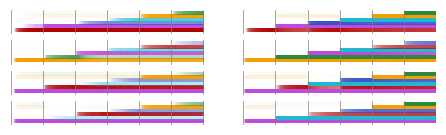

In [5]:
import matplotlib.colors as mcolors
plt.rcParams.update({'font.size': 6,})
fig, axes = plt.subplots(1, 2, figsize=(5.5, 1.5))
n_task = 6
y_gap = 3
n_ckpt = 601
task_order_list = ['PdAdPmAmPdmAdm', 'PdPmAdAmPdmAdm', 'PdmAdmPdAdPmAm', 'PmPdAmAdPdmAdm']
#########################
model_titles = ['OrthoWeightProj', 'ContextRNN']
save_name_fn0 = lambda task_order, seed: f'leakyrnn_v1_proj_relu_{task_order}_AdamWithProj_sd{seed}'
save_name_fn1 = lambda task_order, seed: f'cxtrnn_seq_v2_gating3_ioZ_relu_{task_order}_tskm512_sd{seed}'
##########################
# g1, g2 = 3, 10
# alpha = 0.2
# nonlin = 'relu'
# model_titles = [f'CxtG{g}A{int(alpha*10)}{nonlin}' for g in [g1, g2]]
# alpha_str = {0.1: '', 0.2: '_a0pt2'}[alpha]
# nonlin_str = {'tanh': '', 'relu': '_relu'}[nonlin]
# save_name_fn0 = lambda task_order, seed: f'cxtrnn_seq_v2_gating{g1}_ioZ{alpha_str}{nonlin_str}_{task_order}_tskm512_sd{seed}'
# save_name_fn1 = lambda task_order, seed: f'cxtrnn_seq_v2_gating{g2}_ioZ{alpha_str}{nonlin_str}_{task_order}_tskm512_sd{seed}'
##########################
for i_model, model_title in enumerate(model_titles):
    ax = axes[i_model]
    for i_order, task_order in enumerate(task_order_list):
        ts_arr_seeds = []
        for seed in range(5):
            if i_model == 0:
                save_name = save_name_fn0(task_order, seed)
            else:
                save_name = save_name_fn1(task_order, seed)
            if not os.path.isfile(f'./saved_models/{save_name}/config.json'):
                print(save_name)
                continue
            config = load_config(save_name)
            config['retrain'] = False
            if not os.path.isfile(f'./saved_models/{save_name}/ts_perf_strict.npy'):
                print(save_name)
                continue
            assert config['strict'] == True
            train_fn = eval(config.get('train_fn', 'train_cxtrnn_sequential'))
            model, tr_loss_arr, ts_loss_arr, ts_perf_arr = train_fn(**config)
            ts_arr_seeds.append(ts_perf_arr)
        ts_arr_seeds = np.array(ts_arr_seeds)
        ts_arr_avg = ts_arr_seeds.mean(0)
        for i_task, task_ts in enumerate(config['task_list']):
            plot_y = i_order * (n_task + y_gap) + i_task
            plot_arr = ts_arr_avg[i_task:(i_task + 1)]
            rgba = np.zeros((*plot_arr.shape, 4))
            rgba[..., :3] = mcolors.to_rgb(color_dict[task_ts])
            rgba[..., 3] = plot_arr ** 3  
            ax.imshow(rgba, aspect='auto', extent=[0, n_ckpt, plot_y, plot_y+1], origin='lower')
    print(model_title, sum(p.numel() for p in model.parameters() if p.requires_grad), flush=True)
    ymax = (len(task_order_list) - 1) * (n_task + y_gap) + n_task
    dn_ckpt = config['num_iter'] / config['ckpt_step']
    for ix in range(n_task + 1):
        for i_order in range(len(task_order_list)):
            plot_y = i_order * (n_task + y_gap)
            ax.plot([ix * dn_ckpt + 1] * 2, [plot_y - 0.5, plot_y + n_task + 0.5], color='gray', alpha=1, linewidth=0.5)
    ax.set_xlim(0 - 2, n_ckpt + 2)
    ax.set_ylim(0 - 0.6, ymax + 0.6)
    ax.axis('off')

save_sfx = '_'.join(model_titles)
fig_name = f'./figures/task_order_performance_{save_sfx}.png'
fig.savefig(fig_name, bbox_inches='tight')
fig.savefig(fig_name.replace('.png', '.pdf'), bbox_inches='tight')

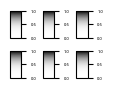

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
plt.rcParams.update({'font.size': 3,})

n = 256
alpha_vals = np.linspace(0, 1, n) ** 3
bg_color = np.ones(3)  

fig, axes = plt.subplots(2, 3, figsize=(1, 1.75))
fig.subplots_adjust(bottom=0.5)
fig.subplots_adjust(wspace=2, hspace=0.5)

task_list = ['PRO_D', 'ANTI_D', 'PRO_M', 'ANTI_M', 'PRO_DM', 'ANTI_DM']
for ax, task in zip(axes.flatten(), task_list):
    base_color = np.zeros(3) #'#np.array(mcolors.to_rgb(color_dict[task]))
    rgba_colors = [(1 - alpha) * bg_color + alpha * base_color for alpha in alpha_vals]
    cmap = ListedColormap(rgba_colors)
    sm = ScalarMappable(cmap=cmap, norm=Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=ax, orientation='vertical')
    # ax.axis('off')
    
fig_name = f'./figures/color_bar.png'
fig.savefig(fig_name, bbox_inches='tight')
fig.savefig(fig_name.replace('.png', '.pdf'), bbox_inches='tight')
# Plot the colorbar

# Create a ScalarMappable with dummy normalization


# Add colorbar


### forward and backward transfer

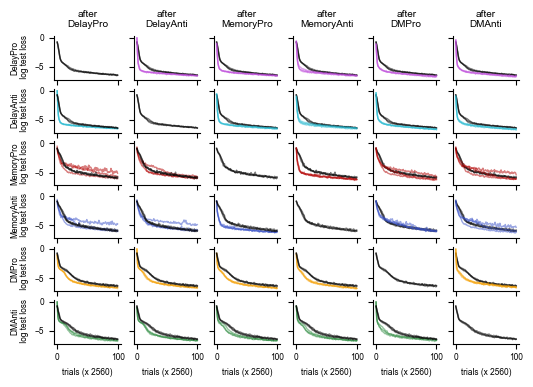

In [15]:
plt.rcParams.update({'font.size': 6,})
check_type = ['forward', 'backward'][0]
task_list_name_fn = lambda cur_task_list: ''.join([cur.split('_')[0][0] + cur.split('_')[1].lower() for cur in cur_task_list])
all_task_list = ['PRO_D', 'ANTI_D', 'PRO_M', 'ANTI_M', 'PRO_DM', 'ANTI_DM']
nonlin_str = '_relu'
nitr_str = '' if check_type == 'forward' else '_nitr10'
sharey = True if check_type == 'forward' else 'row'
fig, axes = plt.subplots(6, 6, figsize=(6, 4), sharey=sharey, sharex=True)
fig.subplots_adjust(wspace=0.2, hspace=0.2)
for itask1, task1 in enumerate(all_task_list):
    for itask2, task2 in enumerate(all_task_list):
        cur_task_list = [task1] if task1 == task2 else [task1, task2]
        cur_task_str = task_list_name_fn(cur_task_list)
        for seed in range(3):
            save_name = f'cxtrnn_seq_v2_gating3_ioZ{nonlin_str}_{cur_task_str}{nitr_str}_tskm512_sd{seed}'
            if not os.path.isfile(f'./saved_models/{save_name}/model.pth'):
                print(save_name)
                continue
            config = load_config(save_name)
            config['retrain'] = False
            model, tr_loss_arr, ts_loss_arr, ts_perf_arr = train_cxtrnn_sequential(**config)
            
            ii = 1 if check_type == 'forward' else 0
            color = color_dict[[task1, task2][ii]] if len(config['task_list']) > 1 else 'k'
            kwargs = dict(color=color, alpha=0.5, linewidth=1)
            plot_y = np.log(ts_loss_arr)
            n_ckpt = int(config['num_iter'] / config['ckpt_step'])
            if itask1 == itask2 and check_type == 'forward':
                plot_y = plot_y[0]
                for ax in axes[[itask1, itask2][ii], :]:
                    ax.plot(plot_y, **kwargs)
            else:
                if check_type == 'forward':
                    plot_y = plot_y[ii][n_ckpt:]
                else:
                    plot_y = plot_y[ii][n_ckpt:]
                axes[[itask1, itask2][ii], [itask1, itask2][1 - ii]].plot(plot_y, **kwargs)
            
for itask, task in enumerate(all_task_list):
    task_label = label_dict[task]
    axes[itask, 0].set_ylabel(task_label + '\n log test loss')
    if check_type == 'forward':
        axes[0, itask].set_title('after\n' + task_label)
    else:
        axes[0, itask].set_title('during\n' + task_label)
    
for ax in axes.flatten():
    ax.spines[['top', 'right']].set_visible(False)
for ax in axes[-1]:
    ax.set_xlabel('trials (x {})'.format(int(256 * config['ckpt_step'])))
fig_name = f'./figures/{check_type}_transfer{nitr_str}.png'
fig.savefig(fig_name, bbox_inches='tight')
fig.savefig(fig_name.replace('.png', '.pdf'), bbox_inches='tight')

### forward transfer example

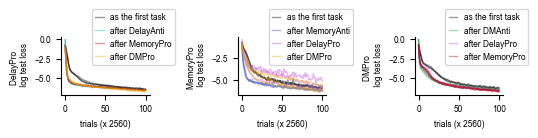

In [6]:
plt.rcParams.update({'font.size': 6,})
task_list_name_fn = lambda cur_task_list: ''.join([cur.split('_')[0][0] + cur.split('_')[1].lower() for cur in cur_task_list])
nonlin_str = '_relu'
task2_list = ['PRO_D', 'PRO_M', 'PRO_DM']
fig, axes = plt.subplots(1, len(task2_list), figsize=(1.9 * len(task2_list), 0.75))
fig.subplots_adjust(wspace=1, hspace=0.2)
for task2, ax in zip(task2_list, axes):
    task1_list = [task2, task2.replace('PRO', 'ANTI')] + [task1 for task1 in ['PRO_D', 'PRO_M', 'PRO_DM'] if task1 != task2]
    for task1 in task1_list:
        cur_task_list = [task1] if task1 == task2 else [task1, task2]
        cur_task_str = task_list_name_fn(cur_task_list)
        for seed in range(3):
            save_name = f'cxtrnn_seq_v2_gating3_ioZ{nonlin_str}_{cur_task_str}_tskm512_sd{seed}'
            config = load_config(save_name)
            config['retrain'] = False
            model, tr_loss_arr, ts_loss_arr, ts_perf_arr = train_cxtrnn_sequential(**config)
            n_ckpt = int(config['num_iter'] / config['ckpt_step'])
            plot_y = np.log(ts_loss_arr)
            plot_y = plot_y[0] if task1 == task2 else plot_y[1][n_ckpt:]
            color = color_dict[task1] if len(config['task_list']) > 1 else 'k'
            label = f'after {label_dict[task1]}' if len(config['task_list']) > 1 else 'as the first task'
            label_kwargs = {} if seed != 0 else dict(label=label)
            ax.plot(plot_y, color=color, alpha=0.4, linewidth=1, **label_kwargs)
    ax.legend(loc='center left', bbox_to_anchor=(0.3, 1), handlelength=1)
    ax.set_ylabel(f'{label_dict[task2]} \n log test loss')
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('trials (x {})'.format(int(config['batch_size'] * config['ckpt_step'])))
fig_name = f'./figures/forward_transfer_example.png'
fig.savefig(fig_name, bbox_inches='tight', transparent=True)
fig.savefig(fig_name.replace('.png', '.pdf'), bbox_inches='tight', transparent=True)

### backward transfer example

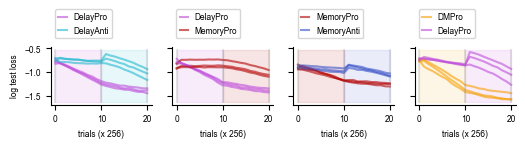

In [8]:
plt.rcParams.update({'font.size': 6,})
task_order_list = ['PdAd', 'PdPm', 'PmAm', 'PdmPd']
fig, axes = plt.subplots(1, len(task_order_list), figsize=(1.5 * len(task_order_list), 0.75),
                         sharex=True, sharey=True)
#########################
save_name_fn = lambda task_order, seed: f'cxtrnn_seq_v2_gating3_ioZ_relu_{task_order}_nitr10_tskm512_sd{seed}'
save_sfx = ''
#########################
# nonlin_str = ['_relu', ''][0]
# nitr = 15
# save_name_fn = lambda task_order, seed: f'leakyrnn_v1_proj{nonlin_str}_{task_order}_nitr{nitr}_AdamWithProj_sd{seed}'
# save_sfx = f'_owp{nonlin_str}_nitr{nitr}'
#########################
for task_order, ax in zip(task_order_list, axes):
    for seed in range(3):
        save_name = save_name_fn(task_order, seed)
        if not os.path.isfile(f'./saved_models/{save_name}/model.pth'):
            print(save_name)
            continue
        config = load_config(save_name)
        config['retrain'] = False
        train_fn = eval(config.get('train_fn', 'train_cxtrnn_sequential'))
        model, tr_loss_arr, ts_loss_arr, ts_perf_arr = train_fn(**config)
        ts_arr = np.log(ts_loss_arr)
        for itask, task_ts in enumerate(config['task_list']):
            label_kwargs = {'label': label_dict[task_ts]} if seed == 0 else {}
            ax.plot(ts_arr[itask], color=color_dict[task_ts], alpha=0.6, **label_kwargs)
ymin, ymax = axes[0].get_ylim()
for task_order, ax in zip(task_order_list, axes):
    save_name = save_name_fn(task_order, 0)
    config = load_config(save_name)
    dn_ckpt = config['num_iter'] / config['ckpt_step']
    for itask in range(len(config['task_list']) + 1):
        ax.plot([itask * dn_ckpt] * 2, [ymin, ymax], alpha=0.2, color='gray')
    for itask, task_ts in enumerate(config['task_list']):
        ax.fill_between([itask * dn_ckpt, (itask + 1) * dn_ckpt], ymin, ymax, 
                         color=color_dict[task_ts], alpha=0.1)
    ax.set_xlabel('trials (x {})'.format(config['batch_size']))
axes[0].set_ylabel('log test loss')
for ax in axes:
    ax.legend(loc='center left', bbox_to_anchor=(0, 1.4), handlelength=1)
    ax.spines[['top', 'right']].set_visible(False)   
if 'leakyrnn_v1_proj_relu' in save_name:
    axes[0].set_ylim(ymin, 0)
fig_name = f'./figures/backward_transfer_example{save_sfx}.png'
fig.savefig(fig_name, bbox_inches='tight')
fig.savefig(fig_name.replace('.png', '.pdf'), bbox_inches='tight')

### few shot learning

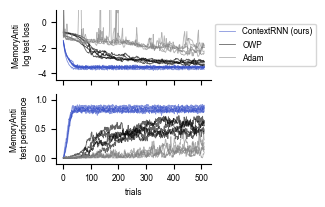

In [10]:
plt.rcParams.update({'font.size': 6,})
task_order = 'PsAsPm'
new_task = 'ANTI_M'
fig, axes = plt.subplots(2, 1, figsize=(2, 2), sharex=True)
ts_perf_collect = [[], [], []]
for i_model in range(3):
    for seed in range(5):
        if i_model == 0: 
            save_name = f'cxtrnn_seq_v2_gating3_ioZ_relu_{task_order}_tskm512_sd{seed}'
            color = color_dict[new_task]
            label = 'ContextRNN (ours)'
            save_sfx = ''
        elif i_model == 1:
            save_name = f'leakyrnn_v1_proj_relu_{task_order}Am_AdamWithProj_sd{seed}' 
            color = 'k'
            label = 'OWP'
            save_sfx = ''
        else:
            save_name = f'leakyrnn_v1_proj_relu_{task_order}Am_AdamWithProj_sd{seed}'
            color = 'gray'
            label = 'Adam'
            save_sfx = '_INIT'  # not using owp and not loading trained model
        config = load_config(save_name)
        config['retrain'] = False
        train_fn = eval(config.get('train_fn', 'train_cxtrnn_sequential'))
        model, _, _, _ = train_fn(**config)
        ts_loss_arr = np.load(f'./saved_models/{save_name}/ts_loss_few_shot{save_sfx}.npy')
        ts_perf_arr = np.load(f'./saved_models/{save_name}/ts_perf_few_shot{save_sfx}.npy')
        ts_err_file = f'./saved_models/{save_name}/ts_err_few_shot{save_sfx}.npy'
        ts_err_arr = np.load(ts_err_file) if os.path.isfile(ts_err_file) else np.zeros(ts_loss_arr.shape)
        task_list = (config['task_list'] + [new_task]) if len(config['task_list']) == 3 else config['task_list']
        itask = task_list.index(new_task)
        for iax, plot_arr in enumerate([np.log(ts_loss_arr), ts_perf_arr]):
            lbl_kwargs = dict(label=label) if seed == 0 else {}
            axes[iax].plot(plot_arr[:512, itask], color=color, alpha=0.6, linewidth=0.6, **lbl_kwargs)
        ts_perf_collect[i_model].append(ts_perf_arr)
    ts_perf_collect[i_model] = np.array(ts_perf_collect[i_model])
axes[0].set_ylabel('MemoryAnti \n log test loss')
axes[1].set_ylabel('MemoryAnti \n test performance')
axes[1].set_xlabel('trials')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
axes[0].set_ylim([-4.5, 1])
axes[1].set_ylim([0-0.1, 1+0.1])
for ax in axes:
    ax.spines[['top', 'right']].set_visible(False)
fig_name = f'./figures/few_shot_example_{task_order}.png'
fig.savefig(fig_name, bbox_inches='tight')
fig.savefig(fig_name.replace('.png', '.pdf'), bbox_inches='tight')

In [11]:
for i_model in range(3):
    print(ts_perf_collect[i_model].mean(0)[40, :])
    print(ts_perf_collect[i_model].mean(0)[-1, :])

[0.98499997 0.97499998 0.91199998 0.82999998]
[0.98199998 0.96899998 0.91199996 0.83099998]
[1.         0.80799998 0.99299999 0.013     ]
[1.         0.77399999 0.999      0.52899998]
[0.    0.001 0.    0.006]
[0.         0.101      0.001      0.20999999]


### sessions below are used for debugging and not well maintained

### plot loss and performance

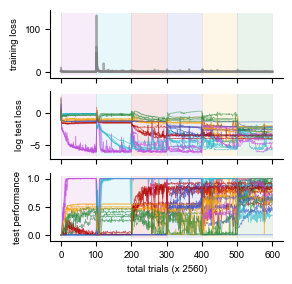

In [14]:
task_order = 'PdAdPmAmPdmAdm'
nonlin_str = '_relu' #'_relu'
num_seed = 5
alpha = 0.6 #0.4
linewidth = 0.5
fig, axes = plt.subplots(3, 1, figsize=(3, 3), sharex=True, sharey=False)
for seed in range(num_seed):
    sfx = '_lmbd0pt01' #''
    save_name = f'hyperrnn_v1{nonlin_str}_sumbeta1{sfx}_{task_order}_sd{seed}'
    fig_name = f'HyperRNN_{task_order}{nonlin_str}{sfx}'
    # save_name = f'nmrnn_rk27_nh256_nz125{nonlin_str}_{task_order}_lr0pt001_sd{seed}'
    # fig_name = f'NMRNN_{task_order}'
    # save_name = f'leakyrnn_v1{nonlin_str}_{task_order}_AdamWithProj_sd{seed}'
    # fig_name = f'Adam_{task_order}'
    # save_name = f'leakyrnn_v1{nonlin_str}_{task_order}_AdamWithProj_sd{seed}'
    # fig_name = 'Adam'
    # save_name = f'leakyrnn_v1_ewc50000{nonlin_str}_{task_order}_AdamWithProj_sd{seed}'
    # fig_name = 'EWC'
    # save_name = f'leakyrnn_v1_proj{nonlin_str}_{task_order}_AdamWithProj_sd{seed}'
    # fig_name = 'OrthoWeightProj'
    # save_name = f'cxtrnn_seq_v2_gating3_ioZ{nonlin_str}_{task_order}_tskm512_sd{seed}'
    # fig_name = 'ContextRNN'
    #####################
    config = load_config(save_name)
    config['retrain'] = False
    train_fn = eval(config.get('train_fn', 'train_cxtrnn_sequential'))
    model, tr_loss_arr, ts_loss_arr, ts_perf_arr = train_fn(**config)    
    axes[0].plot(tr_loss_arr, color='gray', alpha=alpha)
    axes[0].set_ylabel('training loss')
    for iax in [1, 2]:
        ts_arr = [np.log(ts_loss_arr), ts_perf_arr][iax - 1]
        for itask, task in enumerate(config['task_list']):
            label_kwargs = {'label': config['task_list'][itask]} if seed == 0 else {}
            axes[iax].plot(ts_arr[itask], color=color_dict[task], alpha=alpha, 
                           linewidth=linewidth, **label_kwargs)

for irow in range(3):
    axes[irow].set_ylabel(['training loss', 'log test loss', 'test performance'][irow])
axes[-1].set_xlabel('total trials (x {})'.format(config['batch_size'] * config['ckpt_step']))
for ax in axes.flatten():
    ax.spines[['top', 'right']].set_visible(False)

dn_plot = 0
task_list, dn_ckpt = config['task_list'], config['num_iter'] / config['ckpt_step']
for irow in range(3):
    ymin, ymax = axes[irow].get_ylim()
    for itask in range(len(task_list) + 1):
        axes[irow].plot([itask * dn_ckpt + dn_plot] * 2, [ymin, ymax], alpha=0.2, linewidth=0.5, color='gray')
    for itask, task in enumerate(task_list):
        axes[irow].fill_between([itask * dn_ckpt + dn_plot, (itask + 1) * dn_ckpt + dn_plot], ymin, ymax, 
                        color=color_dict[task], alpha=0.1, edgecolor='none')
fig.savefig(f'./figures/{fig_name}.png', bbox_inches='tight', transparent=True)
fig.savefig(f'./figures/{fig_name}.pdf', bbox_inches='tight', transparent=True)

### sequential training

In [4]:
plt.rcParams.update({'font.size': 10,})

In [5]:
save_name = 'cxtrnn_seq_v2_gating3_ioZ_relu_PdmAdmPdAdPmAm_tskm512_sd1' 
config = load_config(save_name)
config['retrain'] = False
model, tr_loss_arr, ts_loss_arr, ts_perf_arr = train_cxtrnn_sequential(**config)
# print(ts_loss_arr[:, -1]) #[0.0025932] #[0.0046438  0.00248593]

In [22]:
save_name = 'leakyrnn_v1_proj_relu_PdPm_nitr10_AdamWithProj_sd0'
config = load_config(save_name)
config['retrain'] = False
model, tr_loss_arr, ts_loss_arr, ts_perf_arr = train_leakyrnn_sequential(**config)

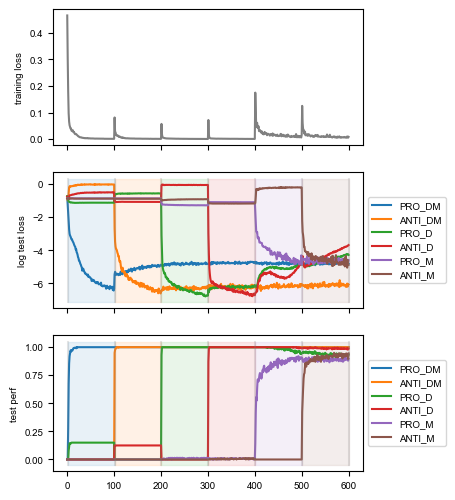

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(4, 6), sharex=True, sharey=False)
axes[0].plot(tr_loss_arr, color='gray')
axes[0].set_ylabel('training loss')
for iax in [1, 2]:
    ts_arr = [np.log(ts_loss_arr), ts_perf_arr][iax - 1]
    ylabel = ['log test loss', 'test perf'][iax - 1]
    for itask in range(len(config['task_list'])):
        axes[iax].plot(ts_arr[itask], color=f'C{itask}', label=config['task_list'][itask])
    axes[iax].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[iax].set_ylabel(ylabel)
    ymin, ymax = axes[iax].get_ylim()
    dn_ckpt = config['num_iter'] / config['ckpt_step']
    for itask in range(len(config['task_list']) + 1):
        axes[iax].plot([itask * dn_ckpt + 1] * 2, [ymin, ymax], alpha=0.2, color='gray')
    for itask in range(len(config['task_list'])):
        axes[iax].fill_between([itask * dn_ckpt + 1, (itask + 1) * dn_ckpt + 1], ymin, ymax, color=f'C{itask}', alpha=0.1)
# if config['save_dir'] is not None:
#     fig.savefig(config['save_dir'] + '/loss.png', bbox_inches='tight')

### checkpoints

In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
ckpt_list = torch.load(config['save_dir'] + '/ckpt_list.pth', map_location=torch.device(device))

In [41]:
dim_z = len(config['z_list'])
U_arr = np.array([ckpt['U'].detach().cpu().numpy() for ckpt in ckpt_list])
V_arr = np.array([ckpt['V'].detach().cpu().numpy() for ckpt in ckpt_list])
fig, axes = plt.subplots(dim_z, 1, figsize=(3, 1.5*dim_z), sharex=True)
for iz in range(dim_z):
    z_t = torch.zeros(dim_z, device=next(model.parameters()).device)
    z_t[iz] = 1
    gating = model.gating(z_t.unsqueeze(0)).detach().cpu().numpy()[0]
    plot_u = (U_arr * np.sqrt(gating)).mean((-1, -2))
    # plot_v = (V_arr * np.sqrt(gating)).mean((-1, -2))
    axes[iz].plot(plot_u, label='mean(Uz)')
    # axes[iz].plot(plot_v, label='mean(Vz)')
    axes[iz].set_ylabel(config['z_list'][iz])
    axes[iz].legend(loc=(1.05, 0.25))
    # ymax = max(plot_u.max(), plot_v.max())
    # ymin = min(plot_u.min(), plot_v.min())
    ymax = plot_u.max()
    ymin = plot_u.min()
    for x in range(len(config['task_list']) + 1):
        axes[iz].plot([x * config['num_iter'] / 10] * 2, [ymin, ymax], alpha=0.2, color='gray')

### task model, if any

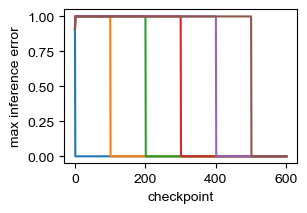

In [5]:
import pickle
if config['use_task_model']:
    with open(config['save_dir'] + '/task_model.pkl', 'rb') as f:
        task_model = pickle.load(f)
        task_model_ckpt_list = pickle.load(f)
        
    ts_err_arr = np.load(config['save_dir'] + '/ts_err.npy')
    fig, ax = plt.subplots(1, 1, figsize=(3, 2))
    for itask in range(ts_err_arr.shape[0]):
        ax.plot(ts_err_arr[itask])
    ax.set_ylabel('max inference error')
    ax.set_xlabel('checkpoint')
else:
    task_model = None

### example trials

In [3]:
dim_s = config.get('dim_s', 3)
dim_y = config.get('dim_y', 3)
if config['z_list'] is None:
    config['z_list'] = get_z_list(config['task_list'], config['epoch_type'])

task = 'PRO_M'
epoch_str = task_epoch(task, epoch_type=config['epoch_type'])
x = 3 #np.random.randint(config['nx'])
sig_y = 0
syz = generate_trial(task, x, config['z_list'], config['task_list'], config['sig_s'], sig_y,
                     config['p_stay'], 20+0*config['min_Te'], config['d_stim'],
                     config['epoch_type'], config['fixation_type'],
                     info_type=config.get('info_type', 'z'),
                     min_Te_R=config.get('min_Te_R', None), p_stay_R=config.get('p_stay_R', None))
syz = torch.tensor(syz[:, None, :], dtype=torch.float32).to(next(model.parameters()).device)
s, y, z = syz[..., :dim_s], syz[..., dim_s:(dim_s + dim_y)], syz[..., (dim_s + dim_y):]
with torch.no_grad():
    out, _ = model(s, z)
print(s.shape, y.shape, out.shape)

torch.Size([80, 1, 5]) torch.Size([80, 1, 3]) torch.Size([80, 1, 3])


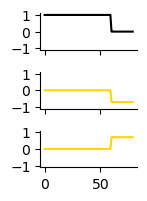

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(1.25, 2), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.6)
# plot_arr = s
# plot_type = 'input'
plot_arr = y
plot_type = 'output'
axes[0].plot(1 - plot_arr[:, 0, -1], color='black')
axes[1].plot(plot_arr[:, 0, 0], color='gold')
axes[2].plot(plot_arr[:, 0, 1], color='gold')
for ax in axes:
    ax.set_ylim([-1.1, 1.1])
    ax.spines[['top', 'right']].set_visible(False)
fig.savefig(f'./figures/schematic_{plot_type}.pdf', bbox_inches='tight', transparent=True)

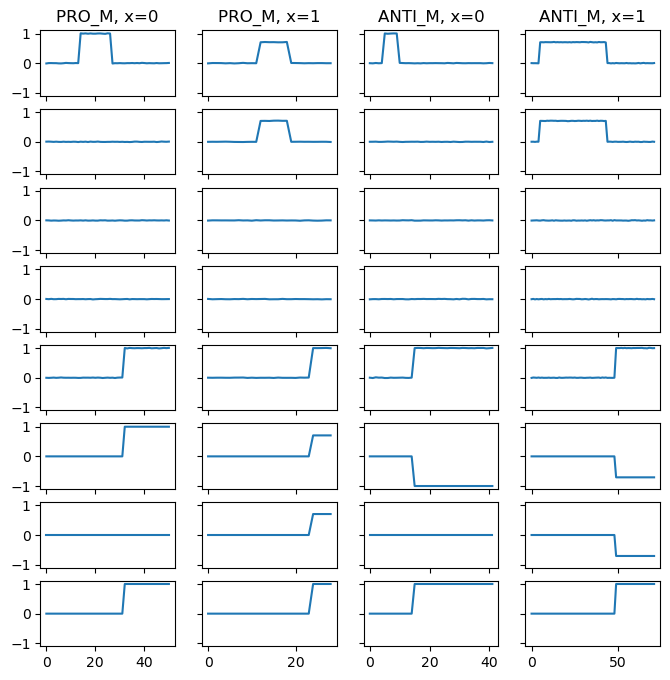

In [7]:
# i_ckpt = -1
# ckpt = ckpt_list[i_ckpt]
# model.load_state_dict(ckpt)

dim_s = config.get('dim_s', 3)
dim_y = config.get('dim_y', 3)
if config['z_list'] is None:
    config['z_list'] = get_z_list(config['task_list'], config['epoch_type'])
task_list = ['PRO_M', 'ANTI_M'] #config['task_list']
x_set = [0, 1] #np.arange(8)
fig, axes = plt.subplots(dim_s + dim_y, len(task_list) * len(x_set), 
                         figsize=(2 * len(task_list) * len(x_set), dim_s + dim_y),
                         sharey=True, sharex='col')
for itask, task in enumerate(task_list):
    for ix, x in enumerate(x_set):
        sig_y = 0
        syz = generate_trial(task, x, config['z_list'], task_list, config['sig_s']/10, sig_y, config['p_stay'],
                             config['min_Te'], config['d_stim'],
                             config['epoch_type'], config['fixation_type'], 
                             info_type=config.get('info_type', 'z'), min_Te_R=config.get('min_Te_R', None),
                             p_stay_R=config.get('p_stay_R', None))
        if config.get('use_task_model', False):
            trial_ = (itask, None, {'s': syz[:, :dim_s], 'y': syz[:, dim_s:(dim_s + dim_y)]})
            inferred_z = task_model.infer(trial_, use_y=False, forward_only=True)[0].sum(axis=(0, 1)).T
            print('max inference error=', np.max(np.abs(inferred_z - syz[:, (dim_s + dim_y):])))
            syz[:, (dim_s + dim_y):] = inferred_z
        syz = torch.tensor(syz[:, None, :], dtype=torch.float32).to(next(model.parameters()).device)
        s, y, z = syz[..., :dim_s], syz[..., dim_s:(dim_s + dim_y)], syz[..., (dim_s + dim_y):]
        with torch.no_grad():
            out, _ = model(s, z)
        ########### plot #########
        icol = len(x_set) * itask + ix
        axes[0, icol].set_title(f'{task}, x={x}')
        for iax in range(dim_s):
            axes[iax, icol].plot(s[:, :, iax].cpu().numpy())
        for iax in range(dim_y):
            # axes[iax + dim_s, icol].plot(out[:, :, iax].cpu().numpy())
            axes[iax + dim_s, icol].plot(y[:, :, iax].cpu().numpy())
# fig.savefig(config['save_dir'] + f'/example_ckpt{i_ckpt}.png', bbox_inches='tight')

### performance

In [14]:
@torch.no_grad()
def batch_performance(out, y, lengths, strict=False):
    seq_len, batch_size, dim_y = out.shape
    if strict:
        out_theta = torch.arctan2(out[:, :, 1], out[:, :, 0])
        y_theta = torch.arctan2(y[:, :, 1], y[:, :, 0])
        d_theta = torch.remainder(out_theta - y_theta + math.pi, 2 * math.pi) - math.pi
        response_correct = d_theta.abs() < math.pi / 10
        mask = torch.arange(seq_len).unsqueeze(1) < lengths.unsqueeze(0)  # seq_len, batch_sze
        mask = mask.to(y.device) & (y[:, :, -1] == y[lengths[0] - 1, 0, -1])
        response_correct = torch.all(response_correct | ~mask, dim=0)
        fixation_correct = (out[..., -1] > 0.5) == (y[..., -1] > 0.5)
        mask = torch.arange(seq_len).unsqueeze(1) < lengths.unsqueeze(0)
        fixation_correct = torch.all(fixation_correct | ~mask.to(y.device), dim=0)
        correct = response_correct & fixation_correct
    else:
        out_end = out[lengths - 1, torch.arange(batch_size)]
        out_theta = torch.arctan2(out_end[:, 1], out_end[:, 0])
        y_end = y[lengths - 1, torch.arange(batch_size)]
        y_theta = torch.arctan2(y_end[:, 1], y_end[:, 0])
        d_theta = torch.remainder(out_theta - y_theta + math.pi, 2 * math.pi) - math.pi
        response_correct = d_theta.abs() < math.pi / 10
        correct = response_correct
    return correct


z_list = get_z_list(config['task_list'], epoch_type=config['epoch_type'])
data_kwargs = dict(dim_s=config.get('dim_s', 5), dim_y=config.get('dim_y', 3), 
                   z_list=z_list, task_list=config['task_list'],
                   sig_s=config['sig_s'], p_stay=config['p_stay'], min_Te=config['min_Te'], 
                   nx=config['nx'], d_stim=config['d_stim'],
                   epoch_type=config['epoch_type'], fixation_type=config['fixation_type'], 
                   info_type=config['info_type'], min_Te_R=config['min_Te_R'])

ts_data_loaders = []
for itask, task in enumerate(config['task_list']):
    ts_dataset = TaskDataset(n_trials=50, task=task, **data_kwargs)
    ts_data_loader = DataLoader(dataset=ts_dataset, batch_size=50, collate_fn=collate_fn)
    ts_data_loaders.append(ts_data_loader)

device = next(model.parameters()).device
for itask_ts, ts_data_loader in enumerate(ts_data_loaders):
    dim_s = ts_data_loader.dataset.dim_s
    dim_y = ts_data_loader.dataset.dim_y
    fixation_type = ts_data_loader.dataset.fixation_type
    for ib, cur_batch in enumerate(ts_data_loader):
        syz, lengths = cur_batch
        syz = syz.to(device)
        s, y, z = syz[..., :dim_s], syz[..., dim_s:(dim_s + dim_y)], syz[..., (dim_s + dim_y):]
        ###########################
        if task_model is not None:
            z, max_error = update_inferred_z(itask_ts, s, y, z, lengths, task_model,
                                             use_y=False, fixation_type=fixation_type)
        ###########################
        out, states = model(s, z)
        break
        perf = batch_performance(out, y, lengths, strict=True)
        

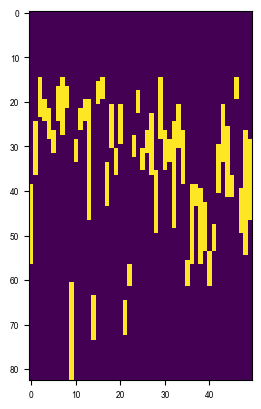

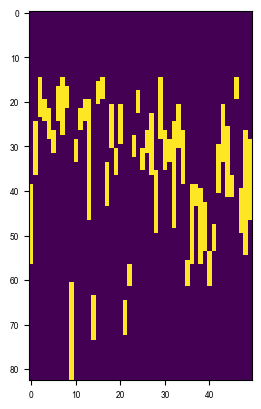

In [20]:
seq_len, batch_size, dim_y = out.shape
mask = torch.arange(seq_len).unsqueeze(1) < lengths.unsqueeze(0)
plt.figure()
plt.imshow(y[:, :, -1])
mask = mask.to(y.device) & (y[:, :, -1] == y[lengths[0] - 1, 0, -1])
plt.figure()
plt.imshow(mask)


### custom epoch sequence

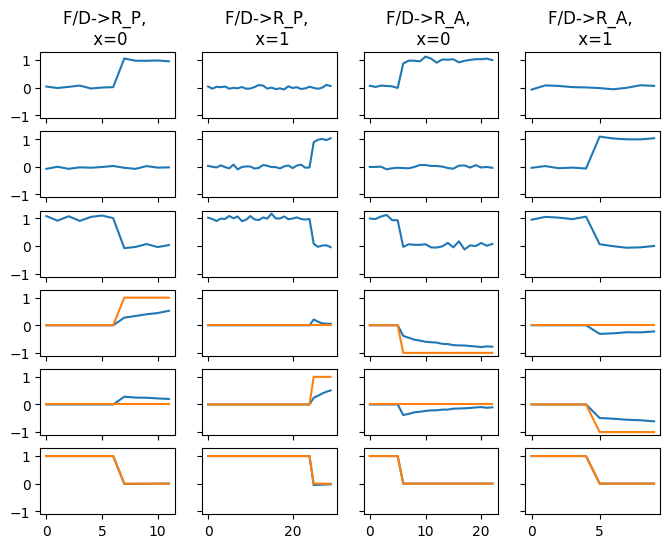

In [116]:
i_ckpt = -1
ckpt = ckpt_list[i_ckpt]
model.load_state_dict(ckpt)

epoch_str_list = ['F/D->S->R_P', 'F/D->S->R_A']
epoch_str_list = ['F/D->R_P', 'F/D->R_A']#['S_S->F/D->R_M_P', 'S_S->F/D->R_M_A', 'S_S->F/D->R_P', 'S_S->F/D->R_A']
# epoch_str_list = ['D->R_M_P', 'S->D->R_M_P', 'S->R_M_P']
# epoch_str_list = ['F/D->R_P', 'S->F/D->R_P', 'S->R_P']
# epoch_str_list = ['F/D->R_A', 'S->F/D->R_A', 'S->R_A']
# epoch_str_list = ['F/D->R_M_P', 'S->F/D->R_M_P', 'S->R_M_P']
# epoch_str_list = ['F/D->R_M_P', 'F/D->R_M_A']
# epoch_str_list = ['S->F/D->R_M_P', 'S->F/D->R_M_A']
x_set = np.arange(config['nx'])
fig, axes = plt.subplots(6, len(epoch_str_list) * len(x_set), 
                         figsize=(2 * len(epoch_str_list) * len(x_set), 6), 
                         sharey=True, sharex='col')

for itask, epoch_str in enumerate(epoch_str_list):
    for ix, x in enumerate(x_set):
        sig_y = 0
        syz = generate_trial(task, x, config['z_list'], config['task_list'], config['sig_s'], sig_y,
                             config['p_stay'], config['min_Te'], config['d_stim'],
                             config['epoch_type'], config['fixation_type'], info_type=config.get('info_type', 'z'),
                             epoch_str=epoch_str)
        syz = torch.tensor(syz[:, None, :], dtype=torch.float32).to(next(model.parameters()).device)
        dim_s = config.get('dim_s', 3)
        dim_y = config.get('dim_y', 3)
        s, y, z = syz[..., :dim_s], syz[..., dim_s:(dim_s + dim_y)], syz[..., (dim_s + dim_y):]
        with torch.no_grad():
            out, _ = model(s, z)
        ########### plot #########
        icol = len(x_set) * itask + ix
        axes[0, icol].set_title(f'{epoch_str}, \n x={x}')
        for iax in range(3):
            axes[iax, icol].plot(s[:, :, iax].cpu().numpy())
        for iax in range(3):
            axes[iax + 3, icol].plot(out[:, :, iax].cpu().numpy())
            axes[iax + 3, icol].plot(y[:, :, iax].cpu().numpy())